# Simple Boston Demo

The PartitionExplainer is still in an Alpha state, but this notebook demonstrates how to use it right now. Note that I am releasing this to get feedback and show how I am working to address concerns about the speed of our model agnostic approaches and the impact of feature correlations. This is all as-yet unpublished work, so treat it accordingly.

When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

In [3]:
import numpy as np
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
import xgboost
import shap
import pandas as pd

## Train the model

In [4]:
X,y = shap.datasets.boston()

model = xgboost.XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

x = X.values[0:1,:]
refs = X.values[1:100] # use 100 samples for our background references (using the whole dataset would be slower)

[11:36:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Compute a hierarchal clustering of the input features

In [5]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

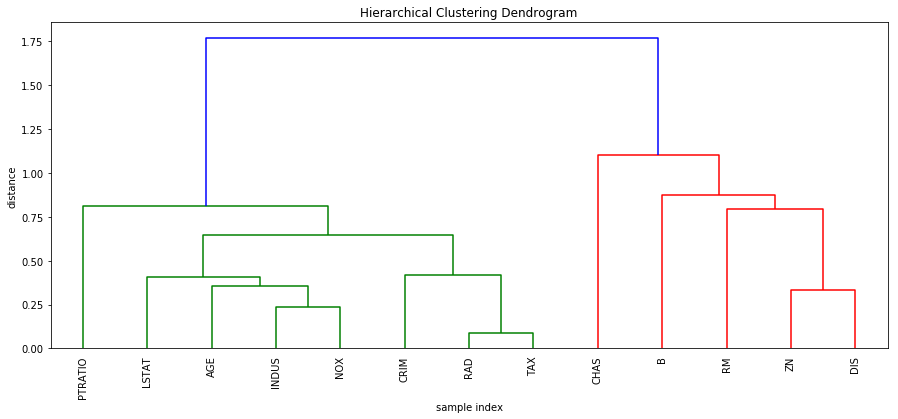

In [6]:
# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

## Explain the first sample with PartitionExplainer

In [12]:
# define the model as a python function 
f = lambda x: model.predict(x, output_margin=True, validate_features=False)

# explain the model
e = shap.PartitionExplainer(f, refs, cluster_matrix)
shap_values = e.shap_values(x, tol=-1)
# ...or use something like e.shap_values(x, tol=0.001) to prune the partition tree and so run faster

## Compare with TreeExplainer

In [13]:
explainer = shap.TreeExplainer(model, refs, feature_dependence="independent")
shap_values2 = explainer.shap_values(x)

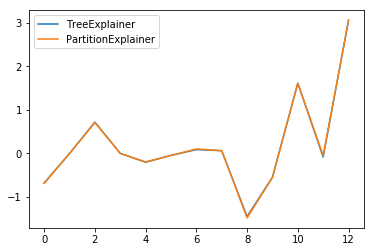

In [14]:
pl.plot(shap_values2[0], label="TreeExplainer")
pl.plot(shap_values[0], label="PartitionExplainer")
pl.legend()